**Import libraries**

In [29]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print("import files suceesfully")

import files suceesfully


In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
EPOCHS = 10
CHANNELS = 3

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

68

In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


**Visualize the dataset**

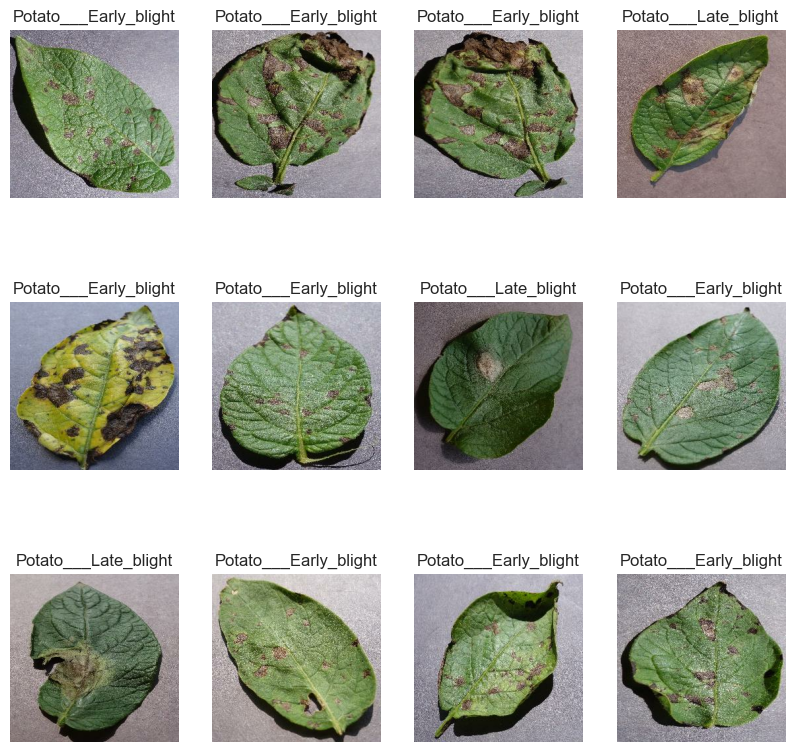

In [10]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

80% ==> training
20% ==> 10%validation, 10% 

In [11]:
len(dataset)

68

In [12]:
def get_dataset_partitions_tf(ds, train_split = 0.8, validation_split = 0.1):

    ds_size = len(ds)

    train_size = int(train_split * ds_size)
    validation_size = int(validation_split * ds_size)

    train_dataset = ds.take(train_size)
    validation_dataset = ds.skip(train_size).take(validation_size)
    test_dataset = ds.skip(train_size).skip(validation_size)

    return train_dataset, validation_dataset, test_dataset

In [13]:
train_ds, validation_ds, test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(validation_ds))
print(len(test_ds))

54
6
8


Cache, Shuffle, and Prefetch the Dataset


In [14]:
train_ds = train_ds.cache().shuffle(10).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = validation_ds.cache().shuffle(10).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10).prefetch(buffer_size=tf.data.AUTOTUNE)

**Building the Model**


In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

Data Augmentation (Flipping, Rotation, Zoom)

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(30/360),
    layers.RandomZoom(0.1)
])

augmented_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
print(augmented_ds)

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


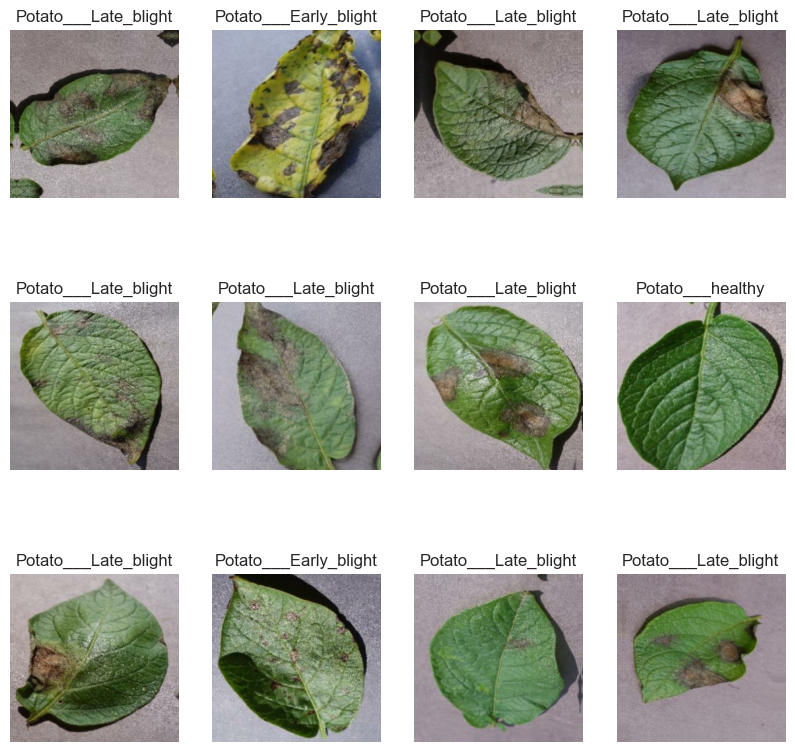

In [17]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in augmented_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

Applying Data Augmentation to Train Dataset


In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

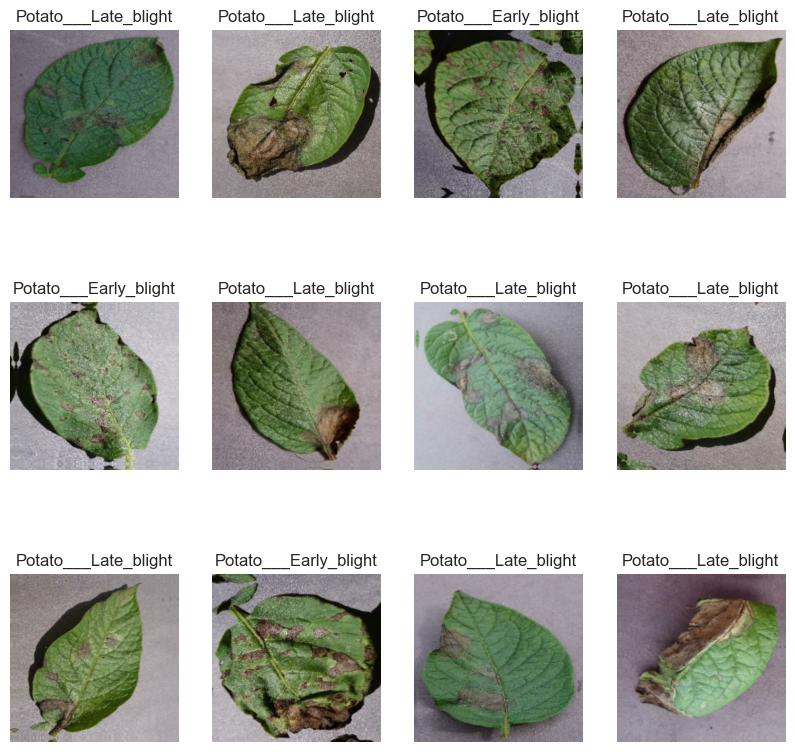

In [19]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

Model Architecture

In [20]:
model = models.Sequential([
        layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    resize_and_rescale,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  #
])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,363 (56.61 MB)

 Trainable params: 14,839,363 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

Compiling the Model


In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 630ms/step - accuracy: 0.6725 - loss: 0.8122 - val_accuracy: 0.8698 - val_loss: 0.2713
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 629ms/step - accuracy: 0.8970 - loss: 0.2426 - val_accuracy: 0.8906 - val_loss: 0.5487
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 622ms/step - accuracy: 0.9057 - loss: 0.2424 - val_accuracy: 0.9271 - val_loss: 0.2229
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 609ms/step - accuracy: 0.9375 - loss: 0.1509 - val_accuracy: 0.9740 - val_loss: 0.0993
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 614ms/step - accuracy: 0.9525 - loss: 0.1322 - val_accuracy: 0.9271 - val_loss: 0.1844
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 613ms/step - accuracy: 0.9618 - loss: 0.1126 - val_accuracy: 0.8906 - val_loss: 0.2482
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 631ms/step - accuracy: 0.9479 - loss: 0.1362 - val_accuracy: 0.8958 - val_loss: 0.2160
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 639ms/step - accuracy: 0.9427 - loss: 0.1632 - val_accu

In [23]:
scores = model.evaluate(test_ds)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9612 - loss: 0.1091


In [24]:
scores

[0.10914668440818787, 0.9612069129943848]

In [32]:
def generate_report(model, test_ds, class_names):
    y_true = []
    y_pred_probs = []
    for images, labels in test_ds:
        y_true.extend(labels.numpy())  # Corrected line
        y_pred_probs.extend(model.predict(images, verbose=0))
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    print("--- Classification Report ---")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))
    # Plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names),
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

--- Classification Report ---
                       precision    recall  f1-score   support

Potato___Early_blight       0.94      1.00      0.97       111
 Potato___Late_blight       0.98      0.93      0.95       102
     Potato___healthy       1.00      0.89      0.94        19

             accuracy                           0.96       232
            macro avg       0.97      0.94      0.96       232
         weighted avg       0.96      0.96      0.96       232



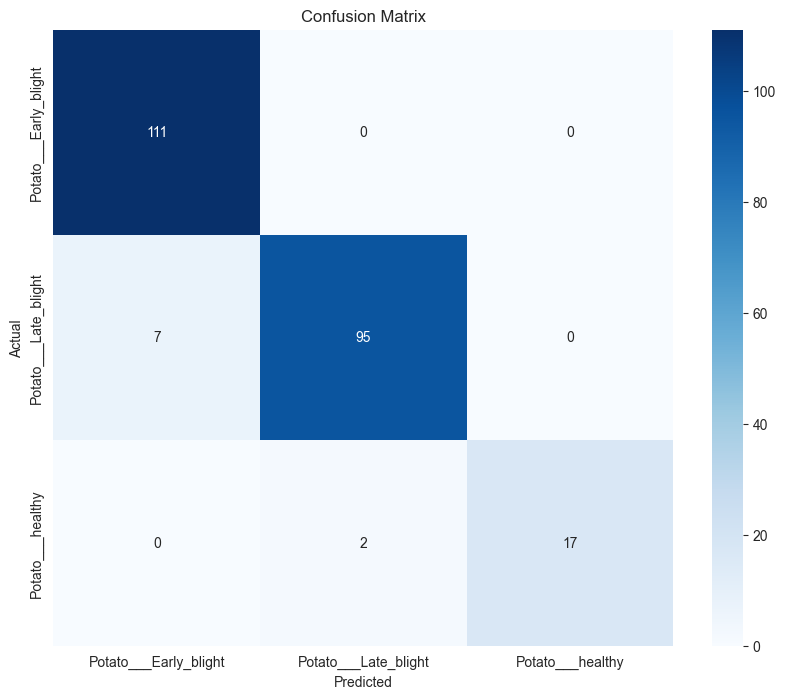

In [33]:
generate_report(model,test_ds,class_names)

actual label: Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
predicted label: Potato___healthy


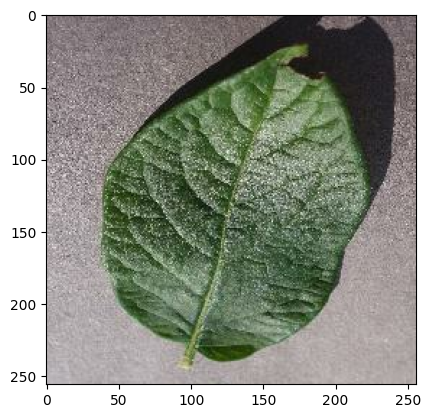

In [147]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [148]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


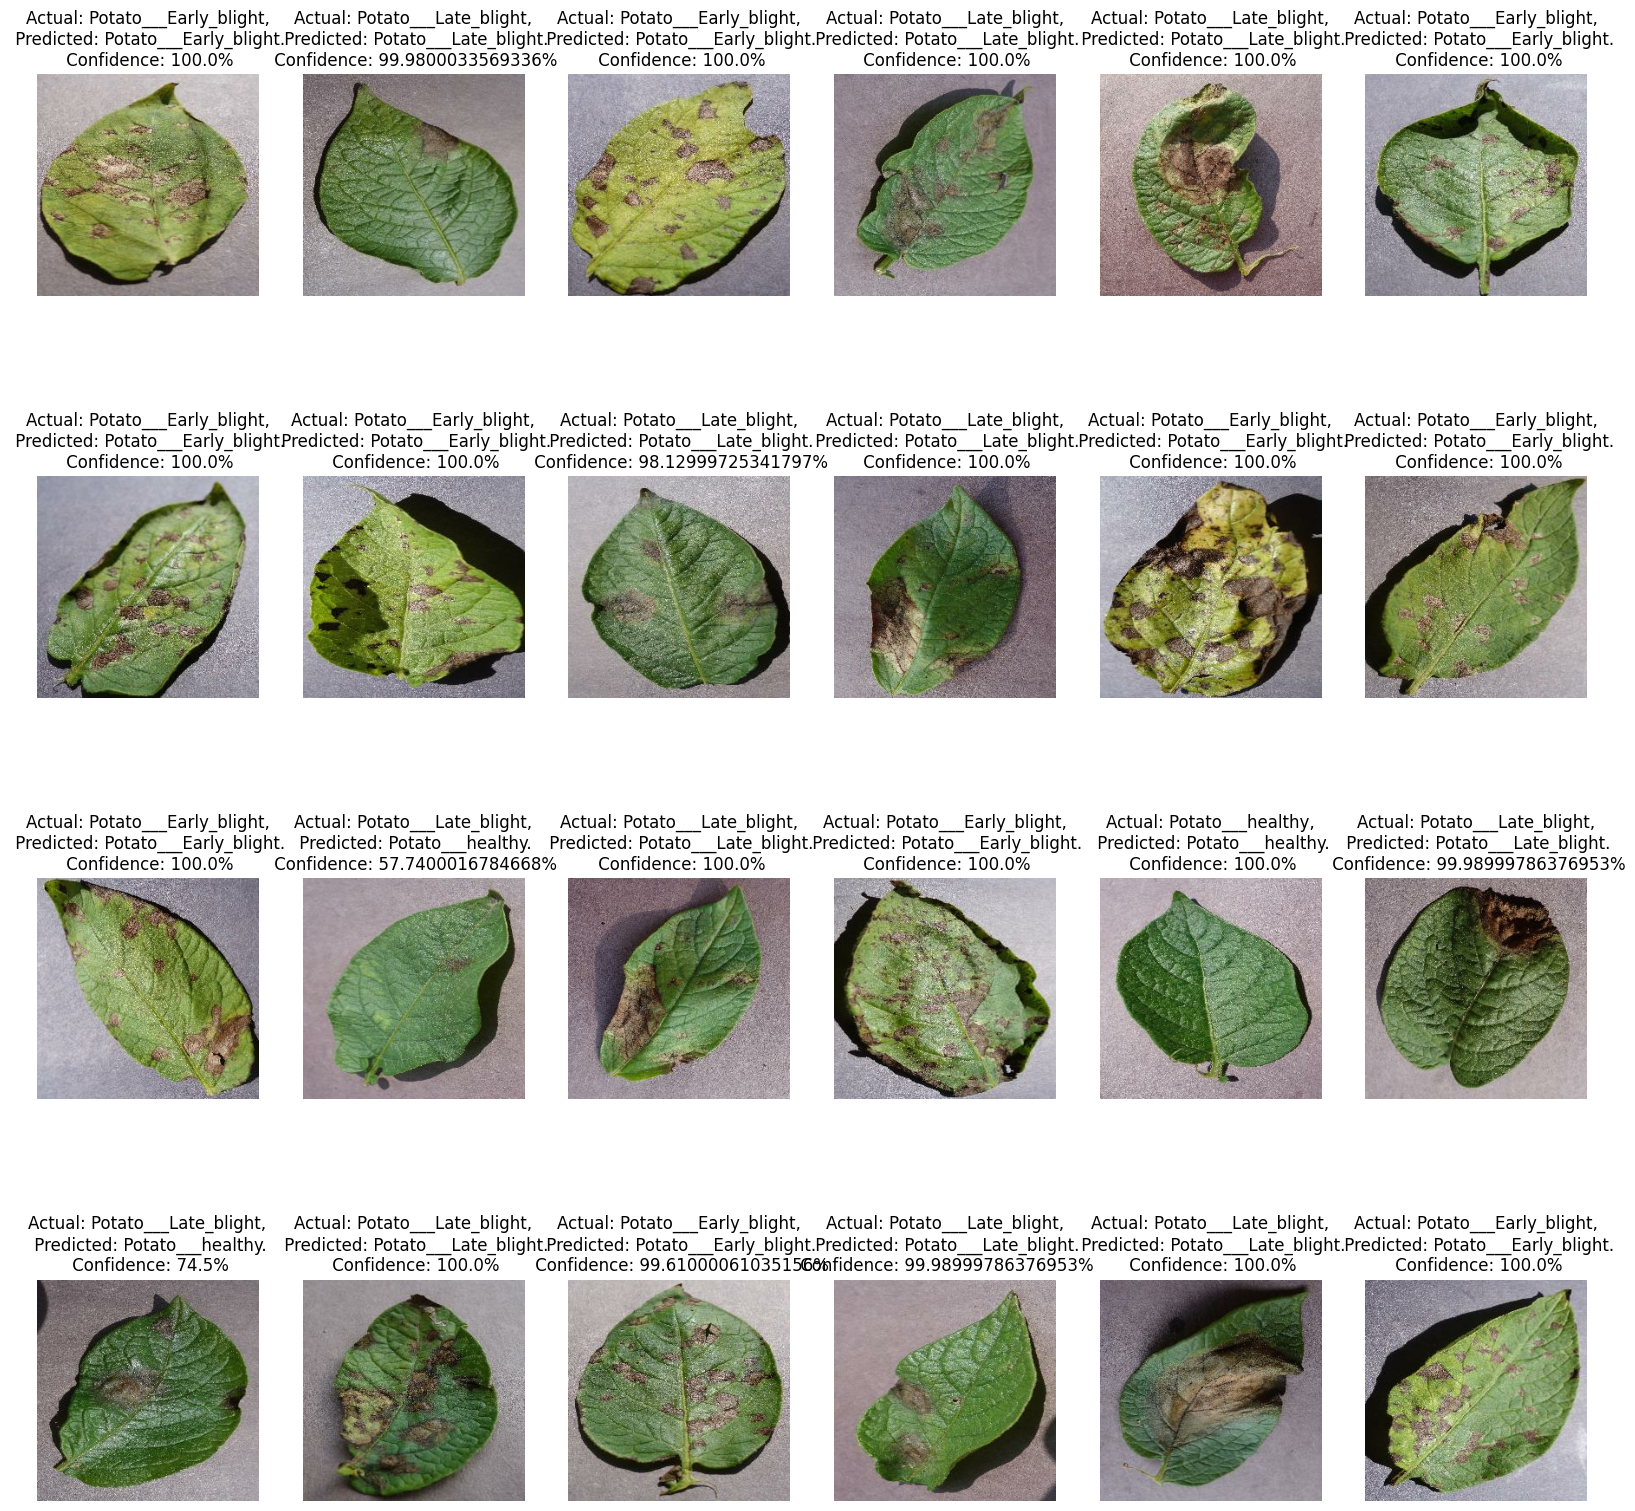

In [153]:

plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(24):
        ax = plt.subplot(4, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")